### <font color='violet'>Import libraries</font>

In [1]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import statistics
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

import contractions
import re
#!pip install transformers # install a library not present in Colab
#!pip install contractions
#!pip install spacy==2.2.3
#!python -m spacy download en_core_web_sm
#!pip install beautifulsoup4==4.9.1
#!pip install textblob==0.15.3
#!pip install contractions
#!pip install transformers
#! conda install text-hammer
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\diego\anaconda3\envs\env1_cloned_tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### <font color='violet'>Preprocessing the datasets</font>

In [36]:
train = pd.read_csv(r'C:\Users\diego\OneDrive\Desktop\DS\Untitled Folder 1\emotions_dataset\train.txt', names=['sentences', 'emotion'], sep=';')
val = pd.read_csv(r'C:\Users\diego\OneDrive\Desktop\DS\Untitled Folder 1\emotions_dataset\val.txt', names=['sentences', 'emotion'], sep=';')
test = pd.read_csv(r'C:\Users\diego\OneDrive\Desktop\DS\Untitled Folder 1\emotions_dataset\test.txt', names=['sentences', 'emotion'], sep=';')
train.head()

,sentences,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [37]:
def Lemmatizer_stop_word(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer() #look at other Lemmatizers and stemmers
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however',
                'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

In [38]:
nltk.download('omw-1.4')
train['sentences'] = train['sentences'].apply(lambda x: Lemmatizer_stop_word(x))
val['sentences'] = val['sentences'].apply(lambda x: Lemmatizer_stop_word(x))
test['sentences'] = test['sentences'].apply(lambda x: Lemmatizer_stop_word(x))
train.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,sentences,emotion
0,did not feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,i am grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger


In [ ]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0)
#train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1))
#train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])

### <font color='violet'>Tokenize the datasets</font>

In [7]:
max_length=43
from transformers import AutoTokenizer, TFBertModel
tokenizer=AutoTokenizer.from_pretrained('bert-base-cased')
bert=TFBertModel.from_pretrained('bert-base-cased')
from tensorflow.keras.layers import Input, Dense
x_train = tokenizer(
    [x.split() for x in train['sentences']],
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    is_split_into_words=True,
    verbose = True)


x_val = tokenizer(
    [x.split() for x in val['sentences']],
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    is_split_into_words=True,
    verbose = True)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
lb = LabelEncoder()
labels_train=lb.fit(train.loc[:,'emotion'].to_list())
labels_train=lb.transform(train.loc[:,'emotion'].to_list())
labels_val=lb.transform(val.loc[:,'emotion'].to_list())
labels_test=lb.transform(test.loc[:,'emotion'].to_list())

### <font color='violet'>Train the model</font>

In [10]:
tf.random.set_seed(79)
#max_len = 43
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical


input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 is the pooler_output)
x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = Dense(138, activation='elu',kernel_initializer='GlorotNormal')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(28,activation = 'elu',kernel_initializer='GlorotNormal')(x)

output = Dense(6,activation = 'softmax')(x)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)
model.layers[2].trainable = True
# for training bert lr must be small


opt = Adam(
    learning_rate=5e-05, # works well with BERTs
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
#model = tf.keras.models.Model( bert_model.input , outputs )
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

#'sparse_categorical_crossentropy' for not one-hot encoded features
# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#bert_model.trainable = False

history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y =labels_train,
    validation_data = (
    {'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']}, labels_val
    ),
  epochs=3,
    batch_size=12,callbacks=[early_stopping_cb]
)

#history=model.fit(padded_docs_train, labels_train, epochs=70,validation_data=(padded_docs_val, labels_val),callbacks=[early_stopping_cb],batch_size=20)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 43)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 43)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
_______________________________________________________

### <font color='violet'> History plot </font>

63/63 [==============================] - 24s 382ms/step - loss: 0.1550 - accuracy: 0.9375
Accuracy: 93.750000


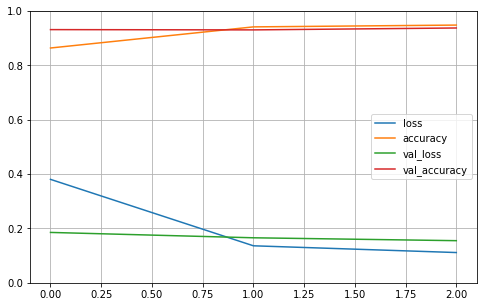

In [15]:
model.save_weights('Bert_stepword_lemmatizer.h5')
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
loss, accuracy = model.evaluate({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']}, labels_val
    )
print('Accuracy: %f' % (accuracy*100))

### <font color='violet'>Load the weights</font>

In [18]:
#rebuild the model to load the weights

input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 is the pooler_output)
x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = Dense(138, activation='elu',kernel_initializer='GlorotNormal')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(28,activation = 'elu',kernel_initializer='GlorotNormal')(x)

output = Dense(6,activation = 'softmax')(x)
    
model_saved = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)
model_saved.layers[2].trainable = True


model_saved.load_weights('Bert_stepword_lemmatizer.h5')

### <font color='violet'>More details about the model</font>

In [19]:
model_saved.summary()

#to visualize activation functions
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
#info about optimizers
model.optimizer.get_config()        

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 43)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 43)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 768)          0           tf_bert_model_1[1][0]      

{'name': 'Adam',
 'clipnorm': 1.0,
 'learning_rate': 5e-05,
 'decay': 0.01,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False}

### <font color='violet'>Tokenize the test dataset</font>

In [20]:
x_test = tokenizer(
    [x.split() for x in test['sentences']],
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    is_split_into_words=True,
    verbose = True)

### <font color='violet'>Predict on test dataset</font>

In [21]:
loss, accuracy = model.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, labels_test
    )
print('Accuracy: %f' % (accuracy*100))

63/63 [==============================] - 6s 90ms/step - loss: 0.1699 - accuracy: 0.9295
Accuracy: 92.949998


In [22]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
#class-label conversion
fin_labels=[i.replace("\n", "") for i in train.loc[:,'emotion'].to_list()]
dict(zip(labels_train,fin_labels))

{4: 'sadness', 0: 'anger', 3: 'love', 5: 'surprise', 1: 'fear', 2: 'joy'}

### <font color='violet'>Predict a new sentence</font>

In [140]:
y=input()

I am glad to see you again


In [141]:
y_s=pd.Series([y])
y_lemm=y_s.apply(lambda x: Lemmatizer_stop_word(x))
y_tok = tokenizer(
    [x.split() for x in y_lemm],
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length',  #only for sentence prediction 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    is_split_into_words=True,
    verbose = True)
#labels_y=lb.transform(test.loc[:,'emotion'].to_list())
y_prob=model.predict({'input_ids':y_tok['input_ids'],'attention_mask':y_tok['attention_mask']})*100
#y_tok
class_label=y_prob.argmax(axis=-1)
lb.inverse_transform(class_label) #from class to label

array(['joy'], dtype='<U8')

In [142]:
{'input_ids':y_tok['input_ids'],'attention_mask':y_tok['attention_mask']} #bert input parameters

{'input_ids': <tf.Tensor: shape=(1, 43), dtype=int32, numpy=
 array([[ 101,  178, 5171, 1267,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>,
 'attention_mask': <tf.Tensor: shape=(1, 43), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>}